In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW

In [ ]:
cuaca =  pd.read_excel('Semarang.xlsx', parse_dates=['Tanggal'], index_col='Tanggal')

In [ ]:
data = cuaca[['Tavg']]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)
seq_length = 30  # Menggunakan data 30 hari sebelumnya untuk memprediksi hari berikutnya
X, y = create_sequences(data_scaled, seq_length)

In [ ]:
# def add_gaussian_noise(data, noise_level=0.02):
#     noise = np.random.normal(0, noise_level, data.shape)
#     # return data + noise

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
# X_train_noisy = add_gaussian_noise(X_train)

In [ ]:
# Membangun model LSTM dengan Dropout dan Gaussian Noise
model_lstm = Sequential([
    # GaussianNoise(0.05, input_shape=(seq_length, 1)),
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(128, activation='tanh')),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer=AdamW(learning_rate=0.0005), loss='mse')

In [ ]:
# model_gru = Sequential([
#     GRU(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
#     GRU(50, activation='relu'),
#     Dense(1)
# ])
# model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [ ]:
# Melatih model LSTM
print("Training LSTM...")
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

# # Melatih model GRU
# print("Training GRU...")
# model_gru.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Training LSTM...
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - loss: 0.0674 - val_loss: 0.0071
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - loss: 0.0061 - val_loss: 0.0052
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 12/50
63/63 ━━━━━━

In [ ]:
# Melakukan prediksi
print("Predicting with LSTM...")
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm)

# print("Predicting with GRU...")
# y_pred_gru = model_gru.predict(X_test)
# y_pred_gru_rescaled = scaler.inverse_transform(y_pred_gru)

y_test_rescaled = scaler.inverse_transform(y_test)

Predicting with LSTM...
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Evaluasi model
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluasi Model {model_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    results_df = pd.DataFrame({
            'Metrik': ['MSE', 'RMSE', 'R2 Score'],
            'Nilai': [mse, rmse, r2]
        })
    results_df.index = results_df['Metrik']  # Set 'Metrik' as index
    results_df = results_df[['Nilai']]  # Keep only the 'Nilai' column
    print(f"\nEvaluasi Model {model_name}:")
    print(results_df)

    return results_df

# Evaluasi model dan simpan ke DataFrame
evaluation_results = evaluate_model(y_test_rescaled, y_pred_lstm_rescaled, "Linear Regression")

# Simpan DataFrame ke file Excel
evaluation_results.to_excel('evaluasi_model_non-scaled.xlsx')


Evaluasi Model Linear Regression:
MSE: 0.5691
RMSE: 0.7544
R2 Score: 0.6976

Evaluasi Model Linear Regression:
             Nilai
Metrik            
MSE       0.569075
RMSE      0.754371
R2 Score  0.697558


In [ ]:
tabel_aktual_prediksi = pd.DataFrame({'Aktual': y_test_rescaled.flatten(), 'Prediksi': y_pred_lstm_rescaled.flatten()}, index=cuaca.index[train_size+seq_length:])
print(tabel_aktual_prediksi)
tabel_aktual_prediksi.to_excel('tabel_aktual_prediksi.xlsx')

            Aktual   Prediksi
Tanggal                      
2022-08-20    28.5  28.919624
2022-08-21    28.6  28.728504
2022-08-22    28.7  28.667021
2022-08-23    28.8  28.664680
2022-08-24    29.8  28.696547
...            ...        ...
2023-12-27    30.9  29.869045
2023-12-28    30.5  30.180777
2023-12-29    31.5  30.206421
2023-12-30    30.0  30.523558
2023-12-31    30.0  30.213825

[499 rows x 2 columns]


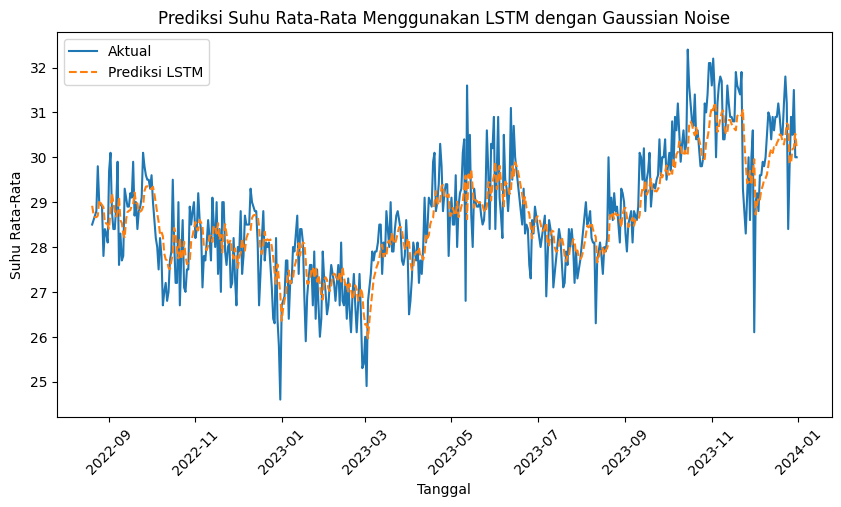

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(cuaca.index[train_size+seq_length:], y_test_rescaled, label='Aktual', linestyle='-')
plt.plot(cuaca.index[train_size+seq_length:], y_pred_lstm_rescaled, label='Prediksi LSTM', linestyle='--')
# plt.plot(cuaca.index[train_size+seq_length:], y_pred_gru_rescaled, label='Prediksi GRU', linestyle='-.')
plt.xlabel("Tanggal")
plt.ylabel("Suhu Rata-Rata")
plt.title("Prediksi Suhu Rata-Rata Menggunakan LSTM dengan Gaussian Noise")
plt.legend()
plt.xticks(rotation=45)
plt.show()


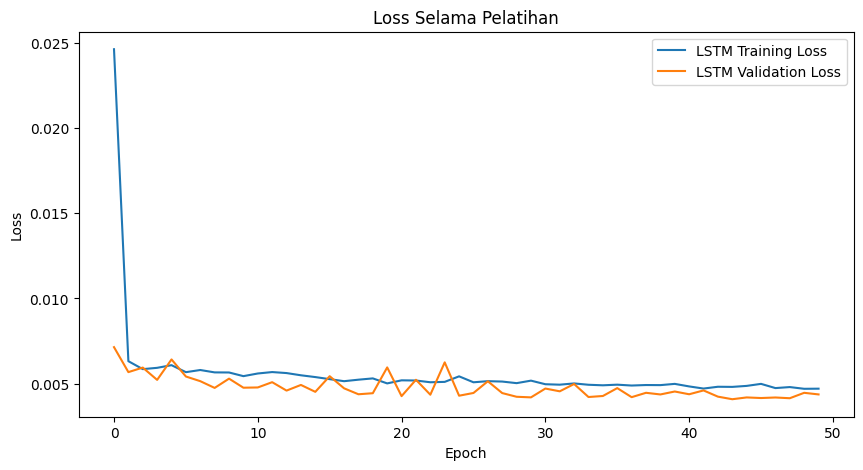

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss')
# plt.plot(history_gru.history['loss'], label='GRU Training Loss')
# plt.plot(history_gru.history['val_loss'], label='GRU Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Selama Pelatihan")
plt.legend()
plt.show()